In [1]:
##import the necessary packages.

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import time

#set the random seed to obtain outcomes.
np.random.seed(0)
tf.random.set_seed(0)

## Data Generation

In [2]:
#Extract the MINIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

#change into black and white
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255


In [3]:
#Seperate the different data
#discard the label data because of unsupervised learning
digit1_train=X_train[y_train==1]
digit2_train=X_train[y_train==2]
digit3_train=X_train[y_train==3]
digit4_train=X_train[y_train==4]
digit5_train=X_train[y_train==5]
digit6_train=X_train[y_train==6]
digit7_train=X_train[y_train==7]
digit8_train=X_train[y_train==8]
digit9_train=X_train[y_train==9]
digit0_train=X_train[y_train==0]


digit1_test=X_test[y_test==1]
digit2_test=X_test[y_test==2]
digit3_test=X_test[y_test==3]
digit4_test=X_test[y_test==4]
digit5_test=X_test[y_test==5]
digit6_test=X_test[y_test==6]
digit7_test=X_test[y_test==7]
digit8_test=X_test[y_test==8]
digit9_test=X_test[y_test==9]
digit0_test=X_test[y_test==0]

In [4]:
#applying the Midpoint Circle Algorithm

#the radius: the objective circle radius
#the height: the rows in pixels
#the width:  the columns in pixels
def Midpoint_circle(radius,height,width):
    pair=[]
    #central point of pixels
    centre_height   = round(((height+1)/2)-1)    #with respect to the original image
    centre_width    = round(((width+1)/2)-1) 
    E= -radius
    X= radius
    Y = 0
    while Y<=X:
        #remove the shift in order to simplify the mirror reflection
        x=X
        y=Y
        #mirror reflection 
        pair.append((x,y))
        pair.append((y,x))
        
        pair.append((x,-y))
        pair.append((y,-x))
        
        pair.append((-x,y))
        pair.append((-y,x))
        
        pair.append((-x,-y))
        pair.append((-y,-x))    
        
        E+=2*Y+1
        Y+=1
        if E >= 0:
            E=E-2*X+1 
            X=X-1
    #add the shift       
    pair_shifted=[]
    for i in range(len(pair)):
        pair_shifted.append((pair[i][0]+centre_width,pair[i][1]+centre_height))
    #remove duplicated records,
    pair_new=[]
    
    for i in pair_shifted:
        if i not in pair_new:
            pair_new.append(i)
    #pair_orderd=np.append(ranked,ranked2,axis=0)
    return pair_new

In [5]:
radius=7
height=19
width=19
pair=Midpoint_circle(radius,height,width)

In [30]:
#Define the function
#The function shifts images in a cicle way to right.

def Shift_c(pair,inputs):
    #shift horizontally function 
    rows,cols=inputs.shape[1:3]
    maxs=max(max(pair))
    data_train=[]
    for k in range(inputs.shape[0]):
        for i,j in pair:
            #fit the data into new position according to equation
            zeros=np.zeros((rows+maxs,cols+maxs))
            zeros[i:i+rows,j:j+cols]=inputs[k]
            data_train.append(zeros)
    data_train=np.asarray(data_train)
    return data_train

In [31]:
data_train_1=Shift_c(pair,digit1_train)
data_test_1=Shift_c(pair,digit1_test)

In [32]:
#Define a function to plot pixels.
def plot_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis("off")

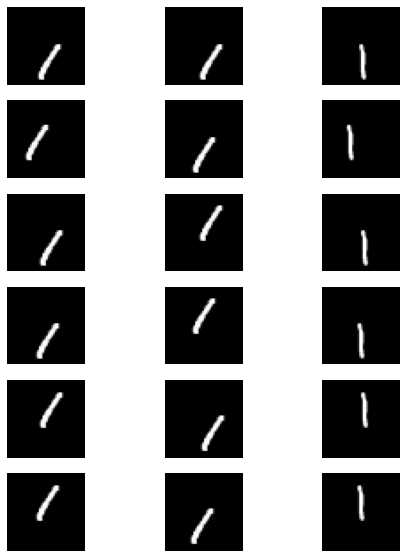

In [33]:
#Show randomly selected observations motion trajectory in frames.

fig = plt.figure(figsize=(8, 10))
index=list(range(0,12,2))
index_=list(range(0,18,3))
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+1)
    plot_image(data_train_1[index[image_index]])
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+2)
    plot_image(data_train_1[12+index[image_index]])
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+3)
    plot_image(data_train_1[120+index[image_index]])
#plt.savefig('digit1.jpg')

In [34]:
data_train_1.shape

(269680, 44, 44)

In [35]:
#Split the dataset into train and valid dataset of digit
x_train=data_train_1[:60000,:]
x_valid=data_train_1[60000:80904,:]

In [36]:
#define the loss function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [37]:
#define the Gaussian distribution according to Reparameterization Trick in order to calculate latent variable z
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [43]:
#define a function to show reconstructions according to the diversity of latent space dimensionality.
#here we only focus on the dimension of latent variable 


#Here we pre-defined the VAE layers so that the shape need to be manually adjusted
def VAE(codings_size_val):
    tf.random.set_seed(42)
    np.random.seed(42)
    ###latent space dimension
    codings_size = codings_size_val
    #Encoder
    inputs = keras.layers.Input(shape=[44, 44])          #pixels according to the inputs
    z = keras.layers.Flatten()(inputs)                   #Flatten the features
    z = keras.layers.Dense(150, activation="selu")(z)    #fully connected Layer 1
    z = keras.layers.Dense(100, activation="selu")(z)    #fully connected Layer 2
    codings_mean = keras.layers.Dense(codings_size)(z)   #Latent space
    codings_log_var = keras.layers.Dense(codings_size)(z)#Sampling Gaussian distribution
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
    ###########################################################################
    #Decoder
    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(100, activation="selu")(decoder_inputs)     #fully connected Layer 1
    x = keras.layers.Dense(150, activation="selu")(x)                  #fully connected Layer 2
    x = keras.layers.Dense(44 * 44, activation="sigmoid")(x)           #Output Layer
    outputs = keras.layers.Reshape([44, 44])(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs]) #combined encoder and decoder
    ###########################################################################
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings) #how to structure reconstructions
    variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
    ###########################################################################
    #regularization term
    latent_loss = -0.5 * K.sum(
        1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
        axis=-1)
    variational_ae.add_loss(K.mean(latent_loss) / 1936.) 
    variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])
    #return the model
    return variational_ae

In [64]:
#define a function to show reconstructions 

def show_reconstructions(model, images=x_valid, n_images=12):
    #randomly selected
    #index=np.random.randint(0,80904,12)
    #all frames of first objects
    index=list(range(12))
    reconstructions = model.predict(images[index])
    fig = plt.figure(figsize=(n_images * 3, 5))
    
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.title('Original image')
        plot_image(images[index[image_index]])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        plt.title('Reconstructed image')




## How we decide the suitable dimensionality of latent space

In [65]:
#the dimension of latent space
Performance_dim=[2,3,5,10]

#the performance of VAE related to the variaty of latent space dimensionality.
def performance(Performance_dim):
    Performance_loss=[]
    Performance_time=[]
    for i in Performance_dim:
        
        variational_ae=VAE(i)
        import time
        time_start=time.time()
        history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
        time_end=time.time()
        time=time_end-time_start
        Performance_time.append(time)
        Performance_loss.append(history.history['loss'][-1])
        show_reconstructions(variational_ae)
        plt.savefig('digit1_circle_dim'+str(i)+'.jpg')
    return Performance_time,Performance_loss

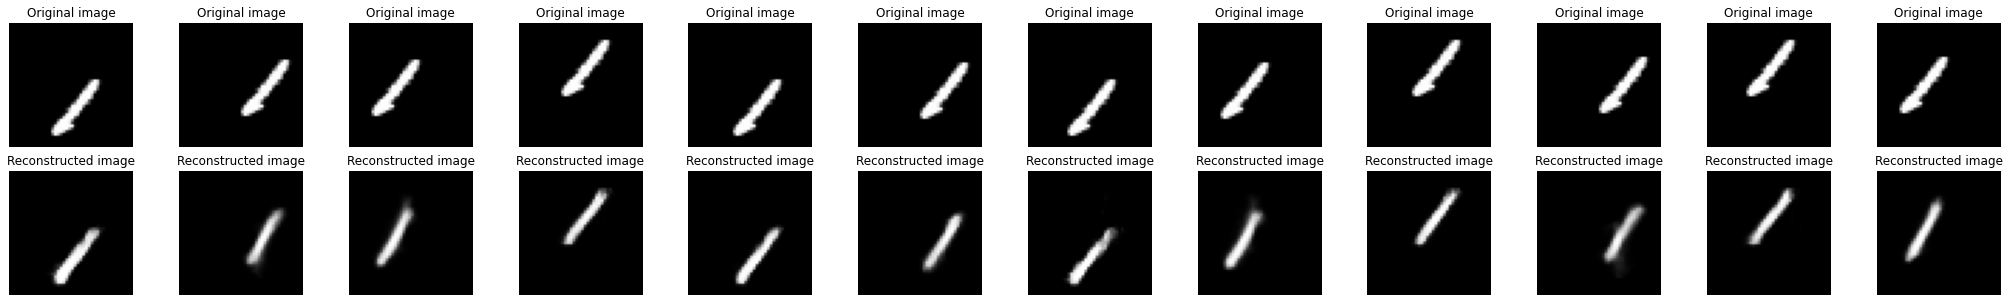

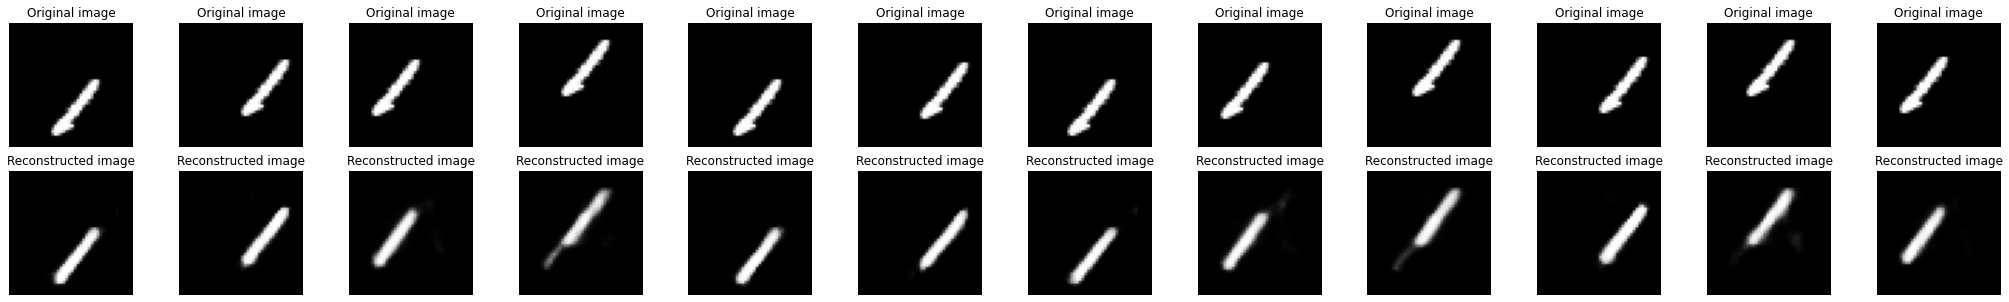

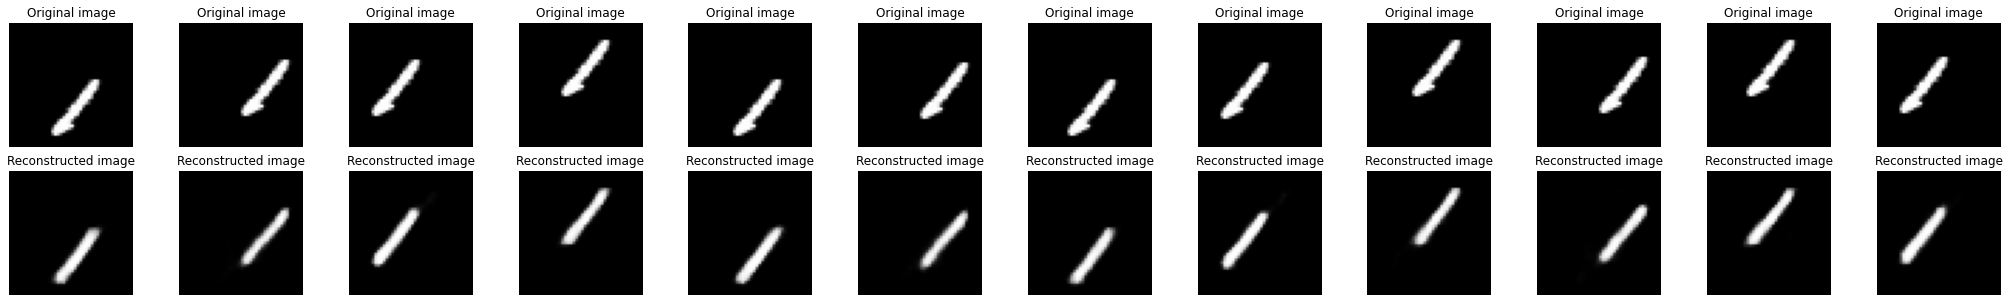

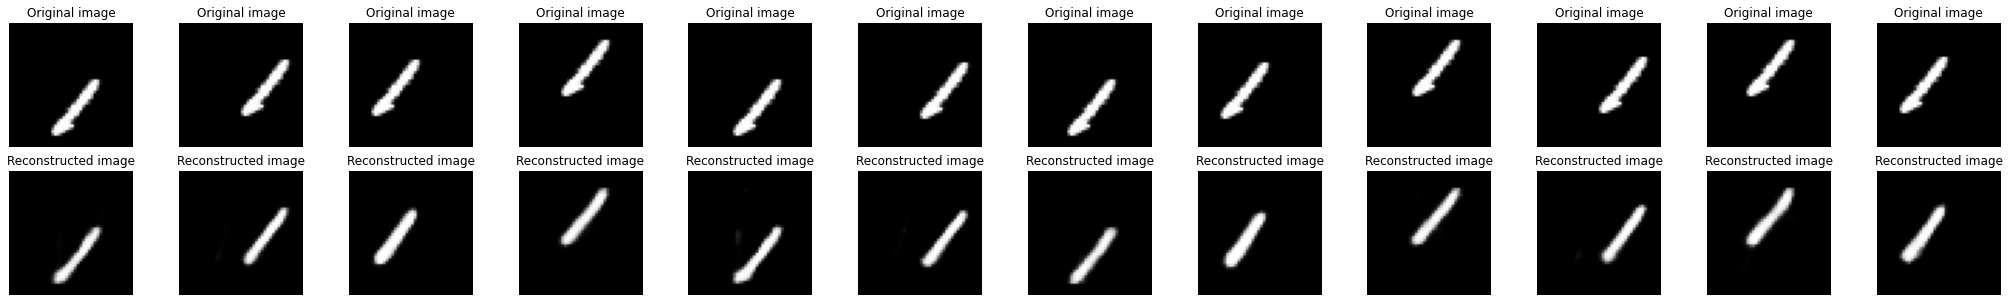

In [66]:
Performance_time,Performance_loss=performance(Performance_dim)

In [67]:
performance = pd.DataFrame({'Dimension': Performance_dim,'loss': Performance_loss, 'time':Performance_time})
performance

,Dimension,loss,time
0,2,0.041853,154.075771
1,3,0.034066,140.179519
2,5,0.031257,148.397966
3,10,0.031360,160.282817


## How to identify the underlying meaning of latent variables in chosen latent space? 

In [49]:
tf.random.set_seed(42)
np.random.seed(42)
#############################################
#according to the previous outcome 
#the latent space dimensionality determined 
codings_size = 2

inputs = keras.layers.Input(shape=[44, 44])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
###########################################################################
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(44 * 44, activation="sigmoid")(x)
outputs = keras.layers.Reshape([44, 44])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
###########################################################################
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
###########################################################################
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1936.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])


history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
latent=variational_encoder(x_valid)[2].numpy()

In [194]:
#summary the statistics of latent variables
df=pd.DataFrame(latent)
summarys=df.describe()
summarys

,0,1
count,20904.000000,20904.000000
mean,-0.213179,-0.076530
std,1.201089,1.437403
min,-5.729706,-4.186355
25%,-0.980747,-1.103364
50%,-0.169730,-0.114791
75%,0.562409,0.926582
max,3.330437,5.878476


### The sampling about quantitive method

In [52]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(10, 10))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.title('Index '+str(index+1))
        plt.axis("off")

In [53]:
#The adjusted latent variables of quantitive method to reveal the underlying meaning of latent variables.
latent_adjust=np.zeros((12,2))
latent_adjust_1=np.zeros((12,2))

latent_adjust[:,0]=latent[:12,0]
latent_adjust_1[:,1]=latent[:12,1]

for i in range(12):
    latent_adjust[i,1]=latent[0,1]
    latent_adjust_1[i,0]=latent[0,0]

latent_adjust.sort(axis=0)
latent_adjust_1.sort(axis=0)
latent_adjust[0,0]=-2
latent_adjust[1,0]=-1.5
latent_adjust[2,0]=-1
latent_adjust[3,0]=-0.5


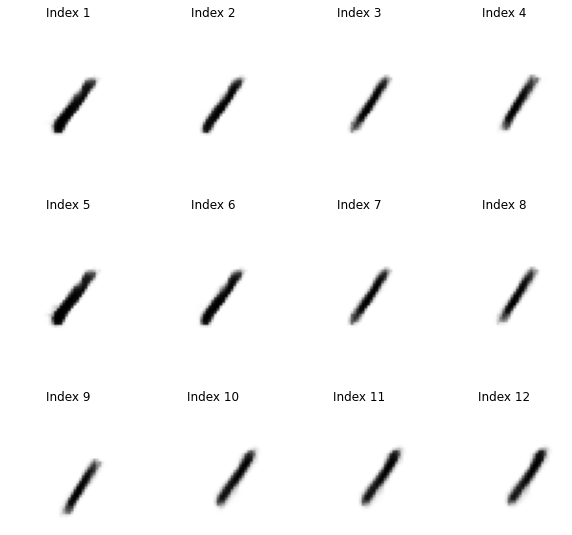

In [54]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjust[:12])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent0.jpg')

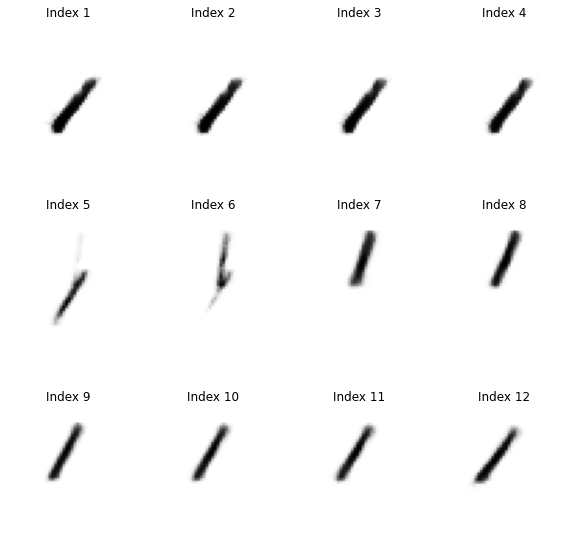

In [55]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjust_1[:12])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent1.jpg')

Here are original values in latent space.

In [56]:
latent_copy=np.zeros((12,2))
latent_copy1=np.zeros((12,2))

latent_copy[:,0]=latent[120:132,0]
latent_copy1[:,1]=latent[120:132,1]


for i in range(12):
    latent_copy[i,1]=latent[120,1]
    latent_copy1[i,0]=latent[120,0]

latent_copy.sort(axis=0)
latent_copy.sort(axis=0)

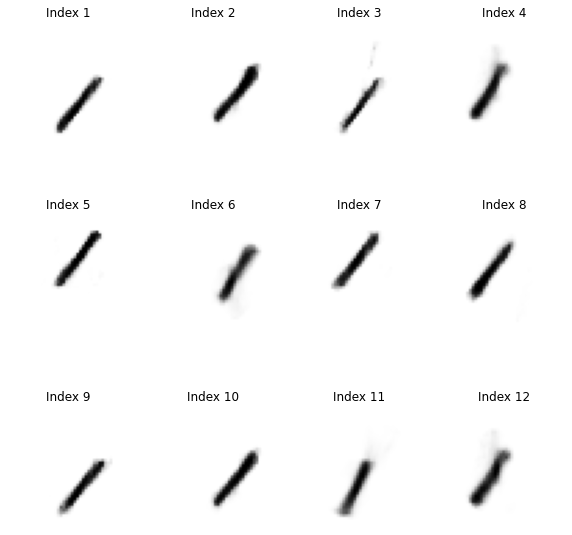

In [57]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent[12:24])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

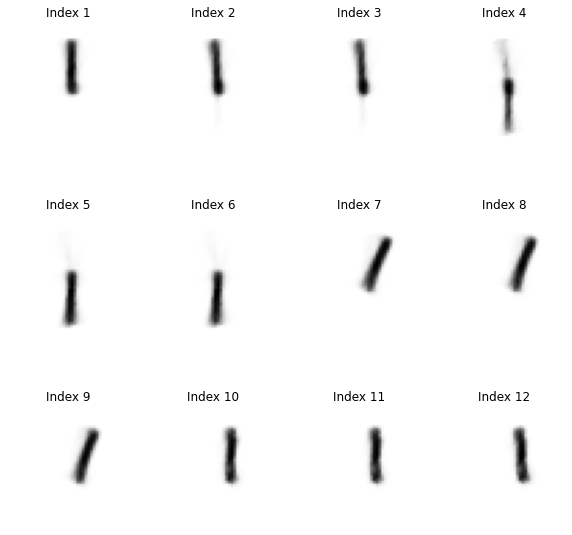

In [58]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent0_example.jpg')

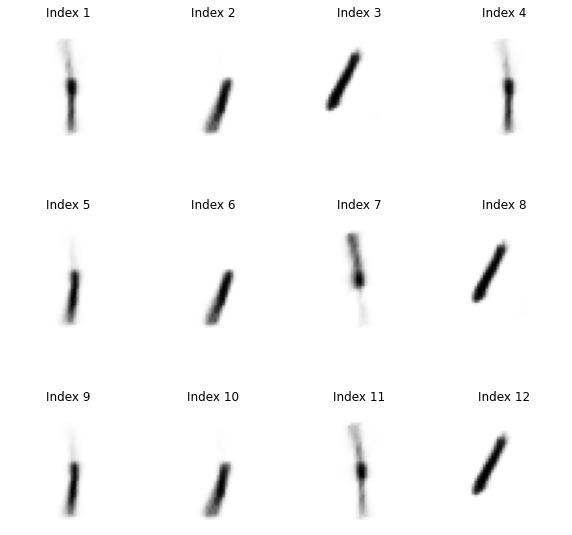

In [59]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent1_example.jpg')

In [60]:
latent_copy_new=np.zeros((12,2))
latent_copy1_new=np.zeros((12,2))

latent_copy_new[:,0]=latent[24:36,0]
latent_copy1_new[:,1]=latent[24:36,1]


for i in range(12):
    latent_copy_new[i,1]=latent[24,1]
    latent_copy1_new[i,0]=latent[24,0]

latent_copy_new.sort(axis=0)
latent_copy1_new.sort(axis=0)

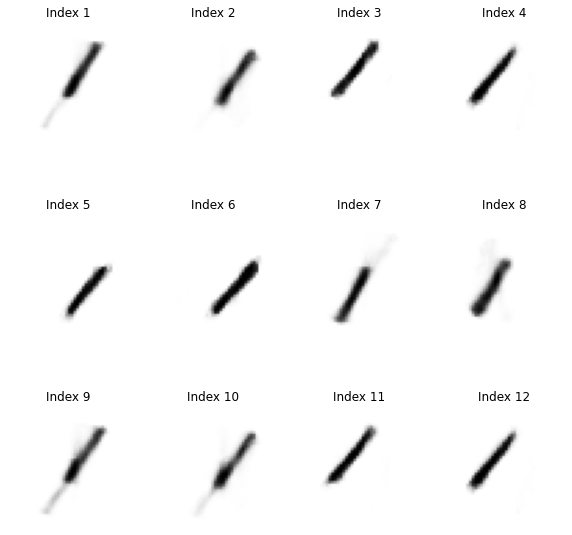

In [61]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent[24:36])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

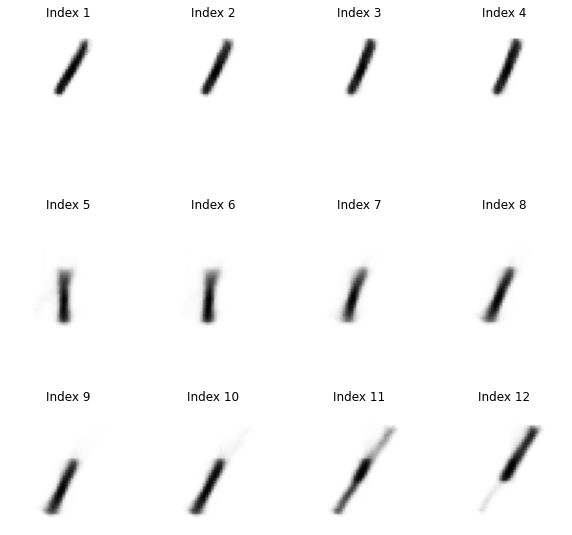

In [62]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy_new[:12])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent0_example1.jpg')

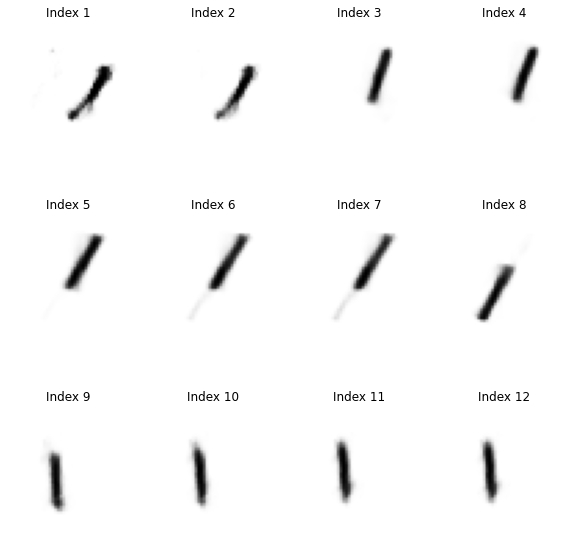

In [63]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy1_new[:12])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit1_latent1_example1.jpg')